In [1]:
%pip -q install timesfm jax seaborn torch statsmodels
import timesfm
import pandas as pd
import numpy as np
#Let's Visualise the Datas
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

Note: you may need to restart the kernel to use updated packages.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.


/home/jovyan/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded PyTorch TimesFM, likely because python version is 3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0].


In [2]:
import os
os.getcwd()

'/home/jovyan/my_materials'

In [3]:
file_path = "../my_materials/data/de_hourly_energy_load.csv"
df = pd.read_csv(file_path, parse_dates=['time'], dayfirst=True)
# Apply seasonal differencing (Assuming 24-hour cycle)
#df['load'] = df['load'] - (df['load'].shift(24*7))
# Drop NaN values created by differencing
df = df.dropna().reset_index(drop=True)
# Take a subset of the data for quicker testing
M = len(df["time"])
print(M)
period = M-2000
data = df[period:] # 300, 500, 700, 1000
data['time']=pd.to_datetime(data['time'])
data.head()
print(len(data['load'])) #load_diff

52608
2000


/tmp/ipykernel_1828/1244901312.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time']=pd.to_datetime(data['time'])


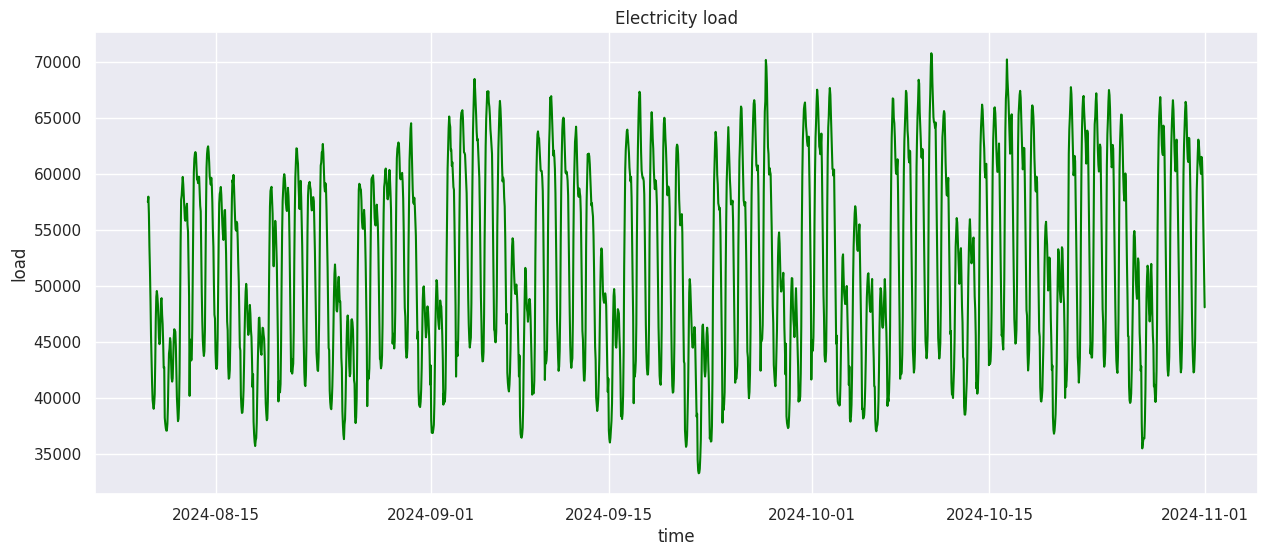

In [4]:
warnings.filterwarnings('ignore') # Settings the warnings to be ignored
sns.set(style="darkgrid")
plt.figure(figsize=(15, 6))
sns.lineplot(x="time", y='load', data=data, color='green')
plt.title('Electricity load')
plt.xlabel('time')
plt.ylabel('load') # load
plt.show()

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Assume 'data' is your original time series DataFrame
result = seasonal_decompose(data['load'], period=24, model='additive')
decomposed_df = pd.DataFrame({
    "time": data["time"],
    "trend": result.trend,
    "seasonal": result.seasonal,
    "residual": result.resid
})
#decomposed_df = decomposed_df.dropna().reset_index(drop=True)
print(decomposed_df.head())  # Check if values exist


                     time  trend     seasonal  residual
50608 2024-08-09 16:00:00    NaN  3996.510579       NaN
50609 2024-08-09 17:00:00    NaN  4757.588641       NaN
50610 2024-08-09 18:00:00    NaN  4576.750925       NaN
50611 2024-08-09 19:00:00    NaN  2646.513437       NaN
50612 2024-08-09 20:00:00    NaN   -45.639764       NaN


In [6]:
# Step 1: Compute first residual (Standard Decomposition)
decomposed_df["load"]= data['load']
decomposed_df["R2"] = data['load'] - decomposed_df["residual"]
decomposed_df["R3"] = decomposed_df["R2"]-(decomposed_df["R2"]).shift(24*7)
decomposed_df["cleaned_load"]=data['load'] - decomposed_df["R3"]
decomposed_df = decomposed_df.dropna().reset_index(drop=True)
print(decomposed_df.head()) 


                 time         trend     seasonal     residual      load  \
0 2024-08-17 04:00:00  46119.708333 -7922.567596  1200.109263  39397.25   
1 2024-08-17 05:00:00  45792.536458 -3055.100478 -2063.185980  40674.25   
2 2024-08-17 06:00:00  45502.802083  1053.366076 -3589.418159  42966.75   
3 2024-08-17 07:00:00  45241.223958  4402.594301 -3872.318260  45771.50   
4 2024-08-17 08:00:00  45013.619792  6461.256701 -3520.376493  47954.50   

             R2          R3  cleaned_load  
0  38197.140737 -414.536458  39811.786458  
1  42737.435980 -338.203125  41012.453125  
2  46556.168159 -279.427083  43246.177083  
3  49643.818260 -257.708333  46029.208333  
4  51474.876493 -258.791667  48213.291667  


In [ ]:
# Step 1: Compute first residual (Standard Decomposition)
decomposed_df["load"]= data['load']
#decomposed_df = decomposed_df.reset_index(drop=True)
print(decomposed_df["load"].iloc[:1])
decomposed_df["R2"]=np.nan
for i in range(len(decomposed_df['residual'])):
    if decomposed_df["residual"].iloc[i]<0:
       #print(decomposed_df["residual"].iloc[i])
       decomposed_df["R2"].iloc[i] = data['load'].iloc[i] + decomposed_df["residual"].iloc[i]
    else:
       decomposed_df["R2"].iloc[i] = data['load'].iloc[i] - decomposed_df["residual"].iloc[i]
   
decomposed_df["R3"] = decomposed_df["R2"]-(decomposed_df["R2"]).shift(24*7)
decomposed_df["cleaned_load"]=np.nan
for i in range(len(decomposed_df['residual'])):
    
    if decomposed_df["R3"].iloc[i]<0:
        decomposed_df["cleaned_load"].iloc[i] = data['load'].iloc[i] + decomposed_df["R3"].iloc[i]
    else:
        decomposed_df["cleaned_load"].iloc[i] = data['load'].iloc[i] - decomposed_df["R3"].iloc[i]#

In [7]:
decomposed_df = decomposed_df.dropna().reset_index(drop=True)
print(decomposed_df.head()) 

                 time         trend     seasonal     residual      load  \
0 2024-08-17 04:00:00  46119.708333 -7922.567596  1200.109263  39397.25   
1 2024-08-17 05:00:00  45792.536458 -3055.100478 -2063.185980  40674.25   
2 2024-08-17 06:00:00  45502.802083  1053.366076 -3589.418159  42966.75   
3 2024-08-17 07:00:00  45241.223958  4402.594301 -3872.318260  45771.50   
4 2024-08-17 08:00:00  45013.619792  6461.256701 -3520.376493  47954.50   

             R2          R3  cleaned_load  
0  38197.140737 -414.536458  39811.786458  
1  42737.435980 -338.203125  41012.453125  
2  46556.168159 -279.427083  43246.177083  
3  49643.818260 -257.708333  46029.208333  
4  51474.876493 -258.791667  48213.291667  


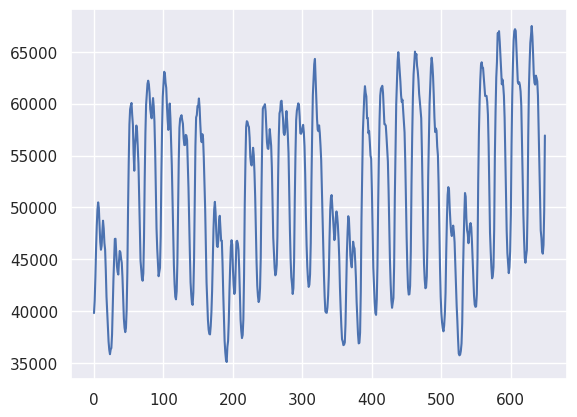

In [8]:
decomposed_df = decomposed_df[:650]
decomposed_df.head()
plt.plot(decomposed_df['cleaned_load'])
plt.show()

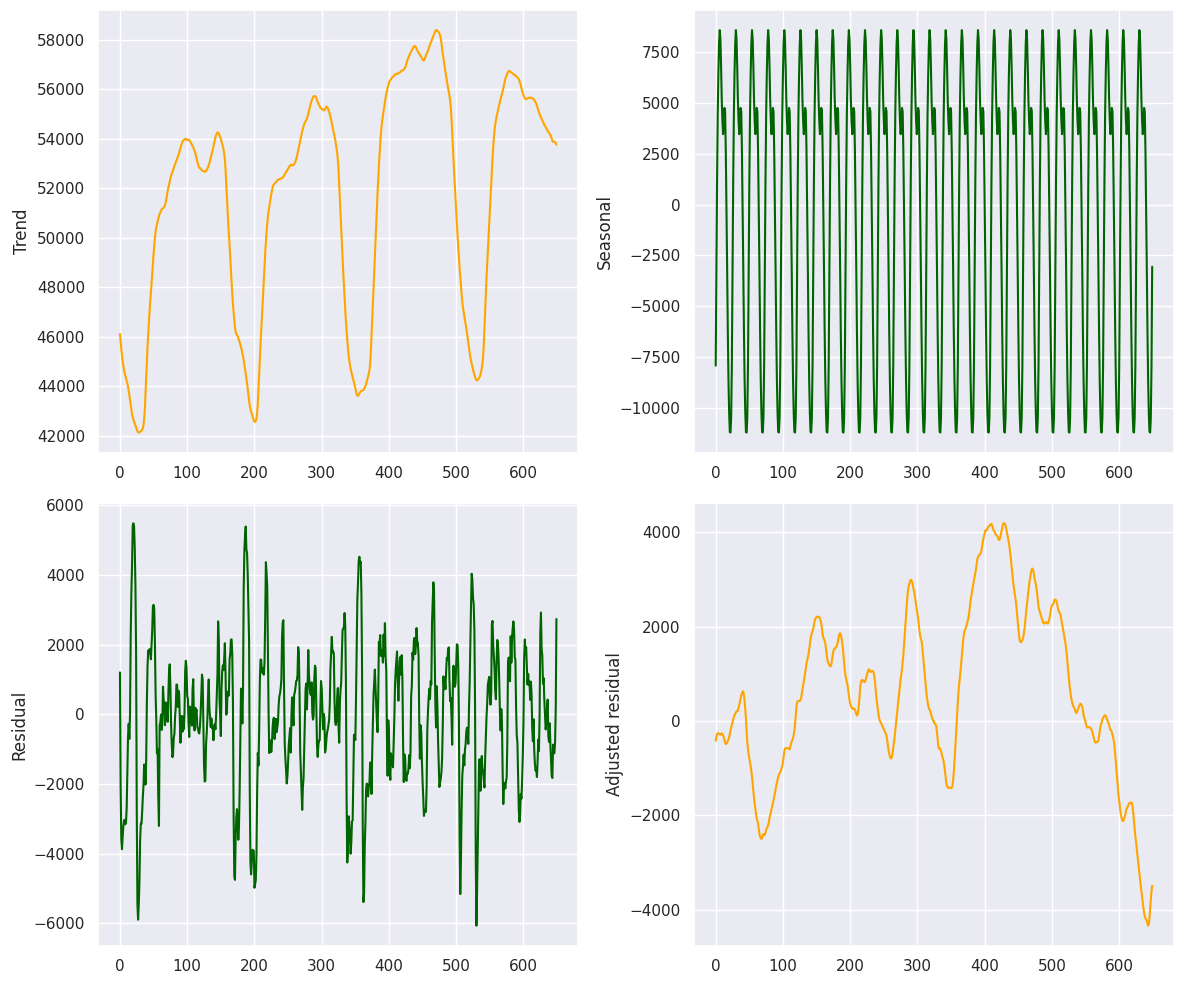

In [24]:
# To create a 2x2 grid for the subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
decomposed_df['trend'].plot(ax=ax1, color='orange')
ax1.set_ylabel('Trend')
decomposed_df['seasonal'].plot(ax=ax2, color='darkgreen')
ax2.set_ylabel('Seasonal')
decomposed_df['residual'].plot(ax=ax3, color='darkgreen')
ax3.set_ylabel('Residual')
decomposed_df['R3'].plot(ax=ax4, color='orange')
ax4.set_ylabel('Adjusted residual')
plt.tight_layout()
plt.show()

In [26]:
# To adjust layout and show the plots
plt.tight_layout()
plt.savefig('hourly load decomposed with TimesFM.png')
plt.show()
#Then reset the index after plotting
#data.reset_index(inplace=True)

<Figure size 640x480 with 0 Axes>

In [ ]:
help(pd.DataFrame)

In [18]:
#df = pd.DataFrame({'unique_id':[1]*len(decomposed_df),'ds': decomposed_df["time"], "y":decomposed_df['cleaned_load']})
# To ensure the correct column names
df = pd.DataFrame({'unique_id': [1] * len(decomposed_df), 'ds': decomposed_df["time"], 'load': decomposed_df['load'], 'cleaned_load':decomposed_df['cleaned_load']})

# we use x to split the data
x=(1-128/len(decomposed_df['cleaned_load']))
split_idx = int(len(df) * x)
# splitting the dataframe into train and test sets
train_df = df[:split_idx]
test_df = df[split_idx:]
print(train_df.shape, test_df.shape)
print(train_df.head())

(522, 4) (128, 4)
   unique_id                  ds      load  cleaned_load
0          1 2024-08-17 04:00:00  39397.25  39811.786458
1          1 2024-08-17 05:00:00  40674.25  41012.453125
2          1 2024-08-17 06:00:00  42966.75  43246.177083
3          1 2024-08-17 07:00:00  45771.50  46029.208333
4          1 2024-08-17 08:00:00  47954.50  48213.291667


In [19]:
# To load TimesFM pretrained checkpoints with hyperparameters
tfm = timesfm.TimesFm(
  hparams = timesfm.TimesFmHparams(
    context_len=512, # max 512, can be shorter
    horizon_len=128,
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend="cpu", # ‘gpu’ when using GPU backend for fine-tuning
  ),
  checkpoint = timesfm.TimesFmCheckpoint(
    huggingface_repo_id="google/timesfm-1.0-200m-pytorch"
  )
)

Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 49539.02it/s]


In [20]:
# To generate forecasts using the TimesFM model on the given DataFrame
timesfm_forecast = tfm.forecast_on_df(
    inputs=train_df,           # Input DataFrame containing the time-series data for training
    freq="H",                  # Frequency of the time-series data (e.g., 'M' for monthly, 'D' for daily)
    value_name="cleaned_load",        # Name of the column containing the values to be forecasted
    num_jobs=-1,               # Number of parallel jobs to use for forecasting (-1 uses all available cores)
)


Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


In [21]:
timesfm_forecast.head()
#test_df.head()

,unique_id,ds,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9
0,1,2024-09-08 00:00:00,39474.304688,38103.515625,38573.589844,38954.773438,39178.640625,39474.304688,39721.105469,39962.019531,40269.570312,40810.351562
1,1,2024-09-08 01:00:00,37506.937500,36261.941406,36761.238281,37147.734375,37359.437500,37506.937500,37865.562500,38073.691406,38390.171875,38891.015625
2,1,2024-09-08 02:00:00,36582.453125,35163.234375,35682.058594,36047.468750,36383.636719,36582.453125,36831.042969,36943.312500,37387.656250,37935.628906
3,1,2024-09-08 03:00:00,35804.425781,34394.027344,35082.851562,35319.156250,35618.039062,35804.425781,36152.402344,36383.031250,36669.503906,37300.066406
4,1,2024-09-08 04:00:00,35287.289062,33744.746094,34320.414062,34719.882812,35104.789062,35287.289062,35580.328125,35849.519531,36146.023438,36684.261719


   level_0  index                time      load  residual   pumped  \
0        0  50608 2024-08-09 16:00:00  57521.50  14273.50  3763.75   
1        1  50609 2024-08-09 17:00:00  57999.50  22507.25  1910.50   
2        2  50610 2024-08-09 18:00:00  56459.25  29742.25   233.25   
3        3  50611 2024-08-09 19:00:00  53527.50  33002.00     1.75   
4        4  50612 2024-08-09 20:00:00  51427.75  33474.00     1.00   

         date      Hour  month  weekday  hour  
0  09/08/2024  16:00:00      8        4    17  
1  09/08/2024  17:00:00      8        4    18  
2  09/08/2024  18:00:00      8        4    19  
3  09/08/2024  19:00:00      8        4    20  
4  09/08/2024  20:00:00      8        4    21  


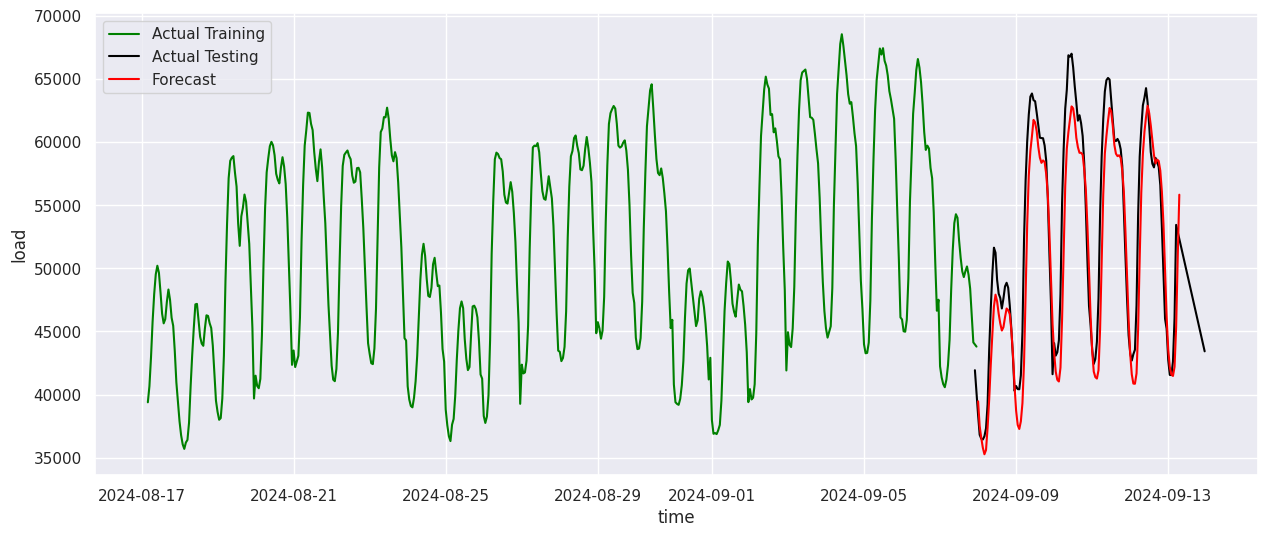

In [22]:
# Let's Visualise the Data
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
print(data.head())
warnings.filterwarnings('ignore') #Again to set the warnings to be ignored
# To set the style for seaborn
sns.set(style="darkgrid")
# Plot size
plt.figure(figsize=(15, 6))
# Plot forecasted value
sns.lineplot(x="ds", y='load', data=train_df, color='green', label='Actual Training')
sns.lineplot(x="ds", y='load', data=test_df, color='black', label='Actual Testing')
# Plot actual timeseries data
sns.lineplot(x="ds", y='timesfm', data=timesfm_forecast, color='red', label='Forecast')
# Set plot title and labels
plt.ylabel('load')
plt.xlabel('time')
#plt.title('Electric Load: Actual vs Forecast')
# Show the legend
plt.legend()
plt.savefig('hourlyload forecast with Time FM.png')
# Display the plot
plt.show()

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# Step 6: Evaluate Performance
mse_test = mean_squared_error(test_df['load'], timesfm_forecast['timesfm'])
mape_test = mean_absolute_percentage_error(test_df['load'], timesfm_forecast['timesfm'])

print("Testing Mean Squared Error (MSE):", mse_test)
print("Testing Mean Absolute Percentage Error (MAPE):", mape_test)

Testing Mean Squared Error (MSE): 8427237.934288144
Testing Mean Absolute Percentage Error (MAPE): 0.048105941579215244
